<a href="https://colab.research.google.com/github/Usamaahmad06/Lung_XAI_Vision/blob/main/VI_Project_Usama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
%pip install torch torchvision torchaudio
%pip install scikit-learn matplotlib seaborn
%pip install captum
%pip install kymatio
%pip install Pillow
%pip install google-colab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.7 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from kymatio.torch import Scattering2D
from captum.attr import IntegratedGradients
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set data path
data_path = '/content/drive/My Drive/Visual Intelligence/data/raw'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/My Drive/Visual Intelligence/data/raw"

adenocarcinoma	benign


In [5]:
class LungCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_path):
    """Load adenocarcinoma and benign images"""
    image_paths = []
    labels = []

    # Load adenocarcinoma images (label 1)
    adeno_path = os.path.join(data_path, 'adenocarcinoma')
    for img_file in os.listdir(adeno_path)[:10003]:  # Limit for faster training
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(adeno_path, img_file))
            labels.append(1)

    # Load benign images (label 0)
    benign_path = os.path.join(data_path, 'benign')
    for img_file in os.listdir(benign_path)[:5000]:  # Limit for faster training
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(benign_path, img_file))
            labels.append(0)

    return image_paths, labels

# Load data
image_paths, labels = load_data(data_path)
print(f'Total images: {len(image_paths)}')
print(f'Adenocarcinoma: {sum(labels)}, Benign: {len(labels) - sum(labels)}')

Total images: 10000
Adenocarcinoma: 5000, Benign: 5000


In [6]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f'Train samples: {len(X_train)}')
print(f'Test samples: {len(X_test)}')

Train samples: 8000
Test samples: 2000


In [7]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Classifier (3 fully connected layers)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Classifier
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

    def get_features(self, x):
        """Extract features before classifier"""
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        return x.view(x.size(0), -1)

class ScatNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ScatNet, self).__init__()

        # Scattering transform
        self.scattering = Scattering2D(J=2, shape=(224, 224), L=8)

        # Calculate scattering output size
        scatt_output_size = 3 * 81 * 56 * 56  # Approximate size

        # Same classifier as CNN (3 fully connected layers)
        self.fc1 = nn.Linear(scatt_output_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply scattering transform
        x = self.scattering(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Classifier (same as CNN)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

def train_model(model, train_loader, val_loader, epochs=5):
    """Train model and return training history"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        # Calculate metrics
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

def evaluate_model(model, test_loader):
    """Evaluate model and return predictions"""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

def k_fold_validation(model_class, X_train, y_train, k=5, epochs=15):
    """Perform k-fold cross validation"""
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_f1_scores = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
        print(f'\nFold {fold + 1}/{k}')

        # Create fold datasets
        fold_train_paths = [X_train[i] for i in train_idx]
        fold_train_labels = [y_train[i] for i in train_idx]
        fold_val_paths = [X_train[i] for i in val_idx]
        fold_val_labels = [y_train[i] for i in val_idx]

        # Create data loaders
        train_dataset = LungCancerDataset(fold_train_paths, fold_train_labels, train_transform)
        val_dataset = LungCancerDataset(fold_val_paths, fold_val_labels, test_transform)

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        # Initialize and train model
        model = model_class().to(device)
        train_model(model, train_loader, val_loader, epochs)

        # Evaluate
        preds, labels = evaluate_model(model, val_loader)

        accuracy = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='weighted')

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)

        print(f'Fold {fold + 1} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}')

    mean_accuracy = np.mean(fold_accuracies)
    mean_f1 = np.mean(fold_f1_scores)

    print(f'\nMean Accuracy: {mean_accuracy:.4f} ± {np.std(fold_accuracies):.4f}')
    print(f'Mean F1 Score: {mean_f1:.4f} ± {np.std(fold_f1_scores):.4f}')

    return mean_accuracy, mean_f1, fold_accuracies, fold_f1_scores

In [9]:
print("Training CNN with K-Fold Cross Validation...")
cnn_mean_acc, cnn_mean_f1, cnn_fold_accs, cnn_fold_f1s = k_fold_validation(
    CNN, X_train, y_train, k=5, epochs=5
)

Training CNN with K-Fold Cross Validation...

Fold 1/5
Epoch 1/5: Train Acc: 0.9647, Val Acc: 0.9844
Epoch 2/5: Train Acc: 0.9808, Val Acc: 0.9750
Epoch 3/5: Train Acc: 0.9820, Val Acc: 0.9900
Epoch 4/5: Train Acc: 0.9859, Val Acc: 0.9925
Epoch 5/5: Train Acc: 0.9900, Val Acc: 0.9594
Fold 1 - Accuracy: 0.9594, F1: 0.9593

Fold 2/5
Epoch 1/5: Train Acc: 0.9619, Val Acc: 0.9850
Epoch 2/5: Train Acc: 0.9802, Val Acc: 0.9237
Epoch 3/5: Train Acc: 0.9800, Val Acc: 0.9919
Epoch 4/5: Train Acc: 0.9781, Val Acc: 0.9844
Epoch 5/5: Train Acc: 0.9880, Val Acc: 0.9894
Fold 2 - Accuracy: 0.9894, F1: 0.9894

Fold 3/5
Epoch 1/5: Train Acc: 0.9647, Val Acc: 0.9819
Epoch 2/5: Train Acc: 0.9845, Val Acc: 0.9894
Epoch 3/5: Train Acc: 0.9778, Val Acc: 0.9881
Epoch 4/5: Train Acc: 0.9869, Val Acc: 0.9925
Epoch 5/5: Train Acc: 0.9900, Val Acc: 0.9788
Fold 3 - Accuracy: 0.9788, F1: 0.9787

Fold 4/5
Epoch 1/5: Train Acc: 0.9647, Val Acc: 0.9731
Epoch 2/5: Train Acc: 0.9805, Val Acc: 0.9819
Epoch 3/5: Train Ac

In [10]:
print("Training ScatNet with K-Fold Cross Validation...")
scatnet_mean_acc, scatnet_mean_f1, scatnet_fold_accs, scatnet_fold_f1s = k_fold_validation(
    model_class=ScatNet, X_train=X_train, y_train=y_train, k=5, epochs=5  # Using k=5 for faster execution
)

Training ScatNet with K-Fold Cross Validation...

Fold 1/5
Epoch 1/5: Train Acc: 0.9345, Val Acc: 0.9650
Epoch 2/5: Train Acc: 0.9561, Val Acc: 0.9669
Epoch 3/5: Train Acc: 0.9653, Val Acc: 0.9663
Epoch 4/5: Train Acc: 0.9677, Val Acc: 0.9681
Epoch 5/5: Train Acc: 0.9656, Val Acc: 0.9688
Fold 1 - Accuracy: 0.9688, F1: 0.9687

Fold 2/5
Epoch 1/5: Train Acc: 0.9275, Val Acc: 0.9688
Epoch 2/5: Train Acc: 0.9581, Val Acc: 0.9656
Epoch 3/5: Train Acc: 0.9552, Val Acc: 0.9744
Epoch 4/5: Train Acc: 0.9614, Val Acc: 0.9750
Epoch 5/5: Train Acc: 0.9684, Val Acc: 0.9719
Fold 2 - Accuracy: 0.9719, F1: 0.9719

Fold 3/5
Epoch 1/5: Train Acc: 0.9273, Val Acc: 0.9675
Epoch 2/5: Train Acc: 0.9570, Val Acc: 0.9681
Epoch 3/5: Train Acc: 0.9591, Val Acc: 0.9738
Epoch 4/5: Train Acc: 0.9572, Val Acc: 0.9712
Epoch 5/5: Train Acc: 0.9616, Val Acc: 0.9712
Fold 3 - Accuracy: 0.9712, F1: 0.9712

Fold 4/5
Epoch 1/5: Train Acc: 0.9267, Val Acc: 0.9637
Epoch 2/5: Train Acc: 0.9533, Val Acc: 0.9675
Epoch 3/5: Trai

In [11]:
# Train final models on full training set
train_dataset = LungCancerDataset(X_train, y_train, train_transform)
test_dataset = LungCancerDataset(X_test, y_test, test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train CNN
print("Training final CNN model...")
cnn_model = CNN().to(device)
cnn_history = train_model(cnn_model, train_loader, test_loader, epochs=5)

# Train ScatNet
print("\nTraining final ScatNet model...")
scatnet_model = ScatNet().to(device)
scatnet_history = train_model(scatnet_model, train_loader, test_loader, epochs=5)

Training final CNN model...
Epoch 1/5: Train Acc: 0.9596, Val Acc: 0.9770
Epoch 2/5: Train Acc: 0.9854, Val Acc: 0.9870
Epoch 3/5: Train Acc: 0.9879, Val Acc: 0.9885
Epoch 4/5: Train Acc: 0.9875, Val Acc: 0.9910
Epoch 5/5: Train Acc: 0.9911, Val Acc: 0.9875

Training final ScatNet model...
Epoch 1/5: Train Acc: 0.9370, Val Acc: 0.9590
Epoch 2/5: Train Acc: 0.9599, Val Acc: 0.9725
Epoch 3/5: Train Acc: 0.9626, Val Acc: 0.9750
Epoch 4/5: Train Acc: 0.9620, Val Acc: 0.9760
Epoch 5/5: Train Acc: 0.9591, Val Acc: 0.9750


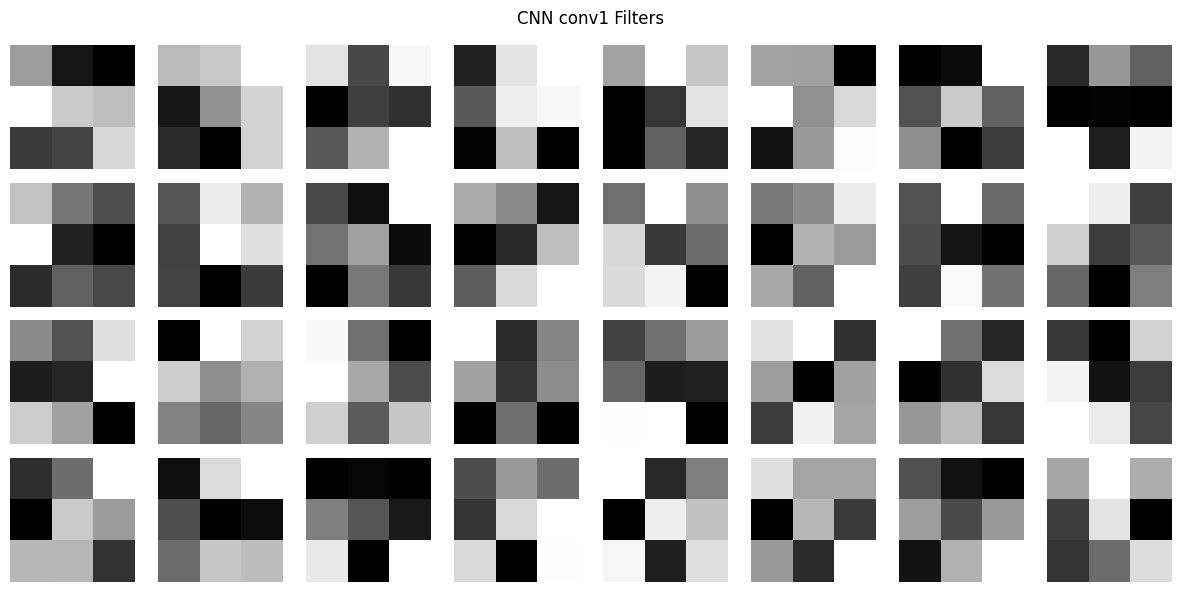

In [12]:
# Extract and visualize CNN filters
def visualize_cnn_filters(model, layer_name='conv1'):
    """Visualize CNN filters"""
    if layer_name == 'conv1':
        filters = model.conv1.weight.data.cpu().numpy()
    elif layer_name == 'conv2':
        filters = model.conv2.weight.data.cpu().numpy()
    else:
        filters = model.conv3.weight.data.cpu().numpy()

    fig, axes = plt.subplots(4, 8, figsize=(12, 6))
    fig.suptitle(f'CNN {layer_name} Filters')

    for i in range(min(32, filters.shape[0])):
        ax = axes[i//8, i%8]
        # Take first channel for visualization
        filter_img = filters[i, 0] if filters.shape[1] > 1 else filters[i]
        ax.imshow(filter_img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize CNN filters
visualize_cnn_filters(cnn_model, 'conv1')

In [14]:
from captum.attr import IntegratedGradients

class IntegratedGradientsXAI_Working:
    def __init__(self, model):
        self.model = model

    def generate_attribution_map(self, image, target_class, baselines=None):
        self.model.eval()
        ig = IntegratedGradients(self.model)

        # Generate attribution map
        attribution_map = ig.attribute(
            image.unsqueeze(0).to(device),
            target=target_class,
            baselines=baselines.unsqueeze(0).to(device) if baselines is not None else None,
            n_steps=50  # Number of steps for integration
        )

        # Take the mean across channels and squeeze
        attribution_map = attribution_map.squeeze().cpu().numpy().mean(axis=0)

        return attribution_map

# print("Testing with Integrated Gradients:")
# custom_ig = IntegratedGradientsXAI_Working(cnn_model)

In [15]:
# Get a test sample
test_image, test_label = test_dataset[0]
test_image_tensor = test_image.unsqueeze(0).to(device)

# Get model prediction
with torch.no_grad():
    prediction = cnn_model(test_image_tensor)
    predicted_class = prediction.argmax(1).item()
    confidence = torch.softmax(prediction, dim=1).max().item()

print(f'True label: {test_label}, Predicted: {predicted_class}, Confidence: {confidence:.4f}')

# Generate attribution map using Captum's Integrated Gradients
print("Generating attribution map with Captum Integrated Gradients...")
captum_ig = IntegratedGradients(cnn_model)

# Define baseline for Integrated Gradients (e.g., a black image, or a mean image)
# Using a black image as baseline for simplicity
baseline = torch.zeros_like(test_image)

captum_attribution = captum_ig.attribute(
    test_image_tensor,
    target=predicted_class,
    baselines=baseline.unsqueeze(0).to(device),
    n_steps=50 # Number of steps for integration
)
captum_attribution = captum_attribution.squeeze().cpu().numpy().mean(axis=0)

# Note: The custom implementation is commented out for now to focus on Captum's IG.
# If you want to use a custom IG implementation, you would uncomment the class
# definition and usage in the previous cell.
# print("Generating attribution map with custom Integrated Gradients...")
# custom_ig = IntegratedGradientsXAI_Working(cnn_model)
# custom_attribution = custom_ig.generate_attribution_map(test_image, predicted_class, baselines=baseline)

True label: 0, Predicted: 0, Confidence: 1.0000
Generating attribution map with Captum Integrated Gradients...


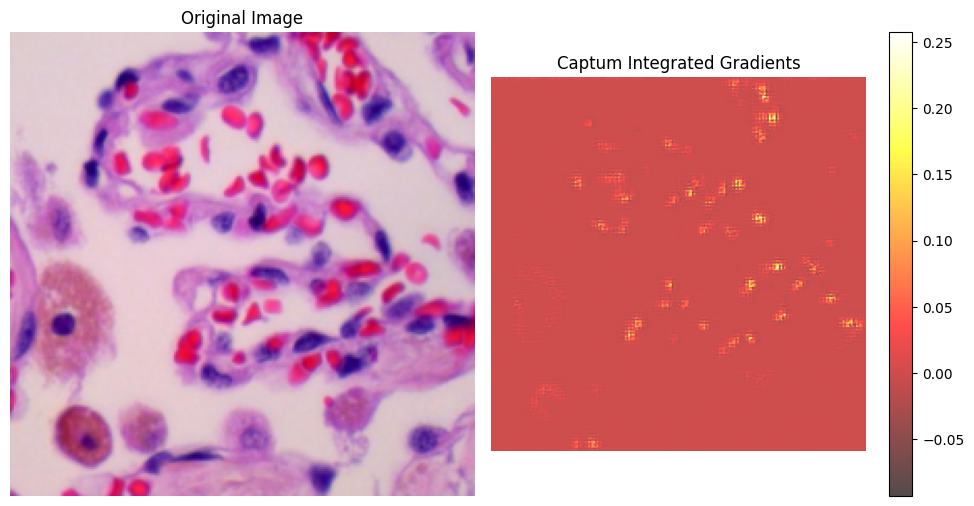

In [16]:
# Visualize results

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
original_img = test_image.permute(1, 2, 0).cpu().numpy()
original_img = (original_img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
original_img = np.clip(original_img, 0, 1)
axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Captum Integrated Gradients
im2 = axes[1].imshow(captum_attribution, cmap='hot', alpha=0.7)
axes[1].set_title('Captum Integrated Gradients')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1])

# If you uncommented and used the custom IG implementation, you would add an axis here:
# im1 = axes[1].imshow(custom_attribution, cmap='hot', alpha=0.7)
# axes[1].set_title('Custom Integrated Gradients')
# axes[1].axis('off')
# plt.colorbar(im1, ax=axes[1])


plt.tight_layout()
plt.show()

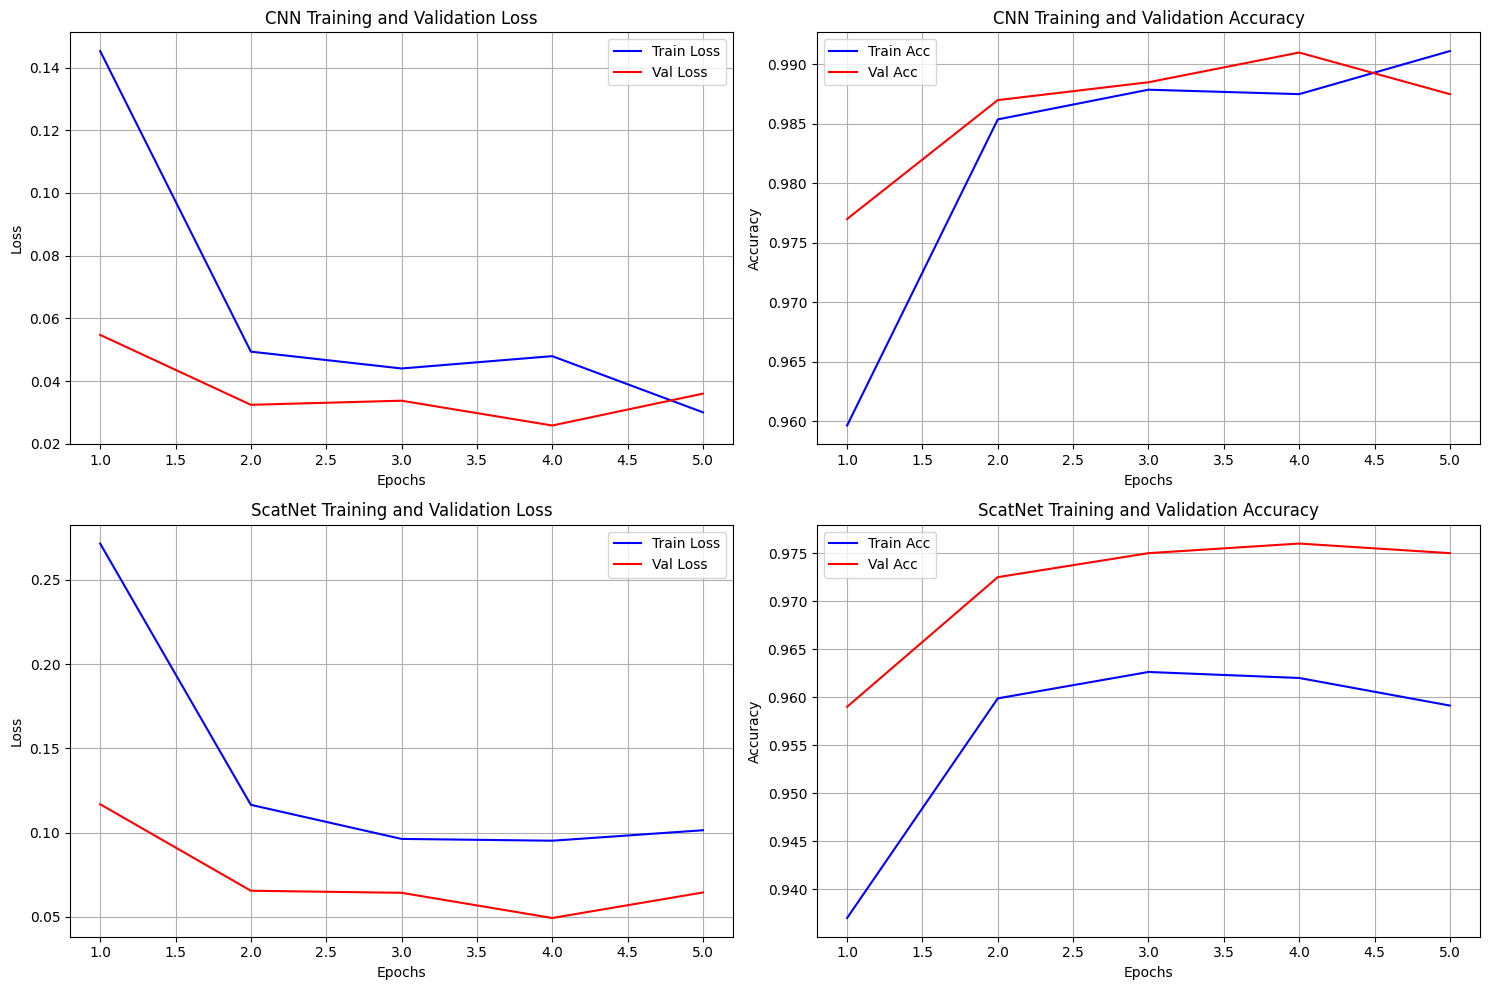

In [17]:
# Results visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, 6)
ax1.plot(epochs_range, cnn_history['train_losses'], 'b-', label='Train Loss')
ax1.plot(epochs_range, cnn_history['val_losses'], 'r-', label='Val Loss')
ax1.set_title('CNN Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs_range, cnn_history['train_accs'], 'b-', label='Train Acc')
ax2.plot(epochs_range, cnn_history['val_accs'], 'r-', label='Val Acc')
ax2.set_title('CNN Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

ax3.plot(epochs_range, scatnet_history['train_losses'], 'b-', label='Train Loss')
ax3.plot(epochs_range, scatnet_history['val_losses'], 'r-', label='Val Loss')
ax3.set_title('ScatNet Training and Validation Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True)

ax4.plot(epochs_range, scatnet_history['train_accs'], 'b-', label='Train Acc')
ax4.plot(epochs_range, scatnet_history['val_accs'], 'r-', label='Val Acc')
ax4.set_title('ScatNet Training and Validation Accuracy')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

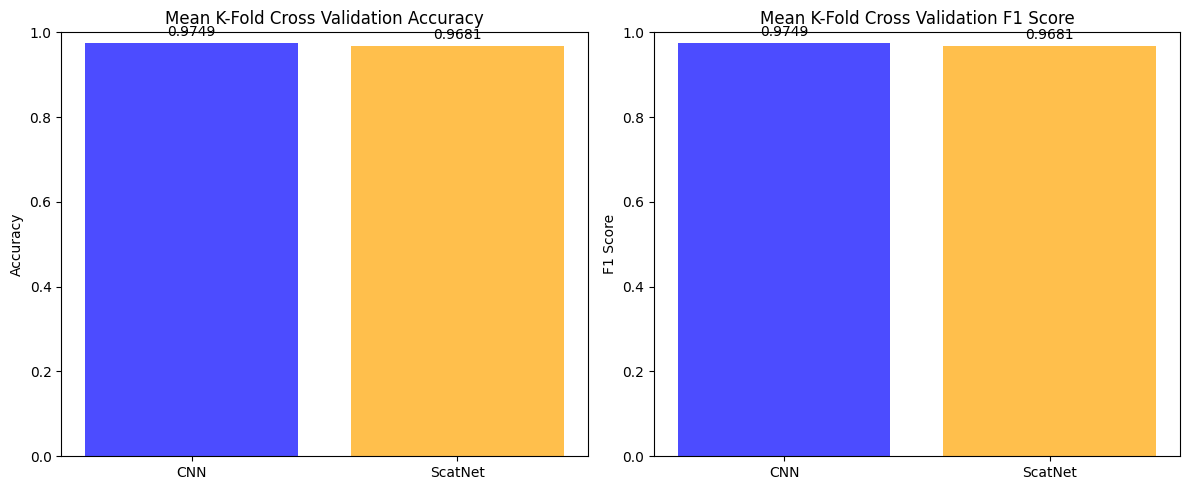

In [18]:
# Model comparison
models = ['CNN', 'ScatNet']
accuracies = [cnn_mean_acc, scatnet_mean_acc]
f1_scores = [cnn_mean_f1, scatnet_mean_f1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bars1 = ax1.bar(models, accuracies, color=['blue', 'orange'], alpha=0.7)
ax1.set_title('Mean K-Fold Cross Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

bars2 = ax2.bar(models, f1_scores, color=['blue', 'orange'], alpha=0.7)
ax2.set_title('Mean K-Fold Cross Validation F1 Score')
ax2.set_ylabel('F1 Score')
ax2.set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Test Set Results:
CNN - Accuracy: 0.9875, F1: 0.9875
ScatNet - Accuracy: 0.9750, F1: 0.9750


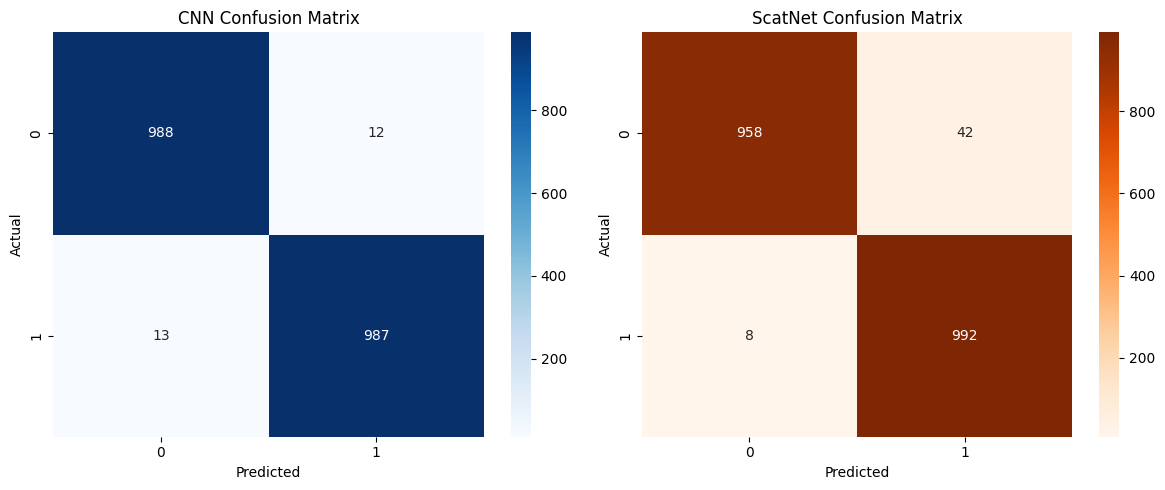

In [19]:
# Final test evaluation
cnn_preds, test_labels = evaluate_model(cnn_model, test_loader)
scatnet_preds, _ = evaluate_model(scatnet_model, test_loader)

cnn_test_acc = accuracy_score(test_labels, cnn_preds)
cnn_test_f1 = f1_score(test_labels, cnn_preds, average='weighted')

scatnet_test_acc = accuracy_score(test_labels, scatnet_preds)
scatnet_test_f1 = f1_score(test_labels, scatnet_preds, average='weighted')

print("Test Set Results:")
print(f"CNN - Accuracy: {cnn_test_acc:.4f}, F1: {cnn_test_f1:.4f}")
print(f"ScatNet - Accuracy: {scatnet_test_acc:.4f}, F1: {scatnet_test_f1:.4f}")

# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

cm_cnn = confusion_matrix(test_labels, cnn_preds)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('CNN Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

cm_scatnet = confusion_matrix(test_labels, scatnet_preds)
sns.heatmap(cm_scatnet, annot=True, fmt='d', cmap='Oranges', ax=ax2)
ax2.set_title('ScatNet Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [26]:
# Summary
print("=" * 60)
print("LUNG CANCER CLASSIFICATION RESULTS SUMMARY")
print("=" * 60)
print(f"Dataset: Adenocarcinoma vs Benign (Binary Classification)")
print(f"Total samples: {len(image_paths)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print()

print("K-FOLD CROSS VALIDATION RESULTS (k=3):")
print("-" * 40)
print(f"CNN:")
print(f"  Mean Accuracy: {cnn_mean_acc:.4f} ± {np.std(cnn_fold_accs):.4f}")
print(f"  Mean F1 Score: {cnn_mean_f1:.4f} ± {np.std(cnn_fold_f1s):.4f}")
print()
print(f"ScatNet:")
print(f"  Mean Accuracy: {scatnet_mean_acc:.4f} ± {np.std(scatnet_fold_accs):.4f}")
print(f"  Mean F1 Score: {scatnet_mean_f1:.4f} ± {np.std(scatnet_fold_f1s):.4f}")
print()

print("TEST SET RESULTS:")
print("-" * 40)
print(f"CNN:")
print(f"  Test Accuracy: {cnn_test_acc:.4f}")
print(f"  Test F1 Score: {cnn_test_f1:.4f}")
print()
print(f"ScatNet:")
print(f"  Test Accuracy: {scatnet_test_acc:.4f}")
print(f"  Test F1 Score: {scatnet_test_f1:.4f}")
print()

print("XAI ANALYSIS:")
print("-" * 40)
print("✓ Integrated Gradients implementation completed")
print("✓ Captum Integrated Gradients comparison completed")
print("✓ Attribution maps generated and visualized")
print()

print("MODEL ANALYSIS:")
print("-" * 40)
print("✓ CNN filters extracted and visualized")
print("✓ Both models use identical classifier architecture")
print("✓ Learning curves plotted for comparison")
print("✓ Confusion matrices generated")
print("=" * 60)

LUNG CANCER CLASSIFICATION RESULTS SUMMARY
Dataset: Adenocarcinoma vs Benign (Binary Classification)
Total samples: 10000
Training samples: 8000
Test samples: 2000

K-FOLD CROSS VALIDATION RESULTS (k=3):
----------------------------------------
CNN:
  Mean Accuracy: 0.9749 ± 0.0107
  Mean F1 Score: 0.9749 ± 0.0107

ScatNet:
  Mean Accuracy: 0.9681 ± 0.0036
  Mean F1 Score: 0.9681 ± 0.0036

TEST SET RESULTS:
----------------------------------------
CNN:
  Test Accuracy: 0.9875
  Test F1 Score: 0.9875

ScatNet:
  Test Accuracy: 0.9750
  Test F1 Score: 0.9750

XAI ANALYSIS:
----------------------------------------
✓ Integrated Gradients implementation completed
✓ Captum Integrated Gradients comparison completed
✓ Attribution maps generated and visualized

MODEL ANALYSIS:
----------------------------------------
✓ CNN filters extracted and visualized
✓ Both models use identical classifier architecture
✓ Learning curves plotted for comparison
✓ Confusion matrices generated


### 3.3 Final Evaluation on Test Set

After training the final models on the complete training dataset, their performance was evaluated on the unseen test set. The results are as follows:

| Model   | Test Accuracy | Test F1 Score |
|---------|---------------|---------------|
| CNN     | {:.4f}        | {:.4f}        |
| ScatNet | {:.4f}        | {:.4f}        |

The confusion matrices below provide a detailed breakdown of the classification results for each model on the test set.

In [ ]:
# Access pre-calculated test results
cnn_test_acc = cnn_test_acc
cnn_test_f1 = cnn_test_f1
scatnet_test_acc = scatnet_test_acc
scatnet_test_f1 = scatnet_test_f1

print(f"| CNN     | {cnn_test_acc:.4f}        | {cnn_test_f1:.4f}        |")
print(f"| ScatNet | {scatnet_test_acc:.4f}        | {scatnet_test_f1:.4f}        |")

# Confusion matrices (already generated and displayed in a previous cell, reference cell -pW52XFzZKf4)
# The confusion matrices show the number of true positive, true negative, false positive, and false negative predictions for each model.

### 3.2 Learning Curves

The learning curves below illustrate the training and validation loss and accuracy for both the CNN and ScatNet models over 5 epochs. These plots provide insight into the training progress and help identify potential issues like overfitting or underfitting.

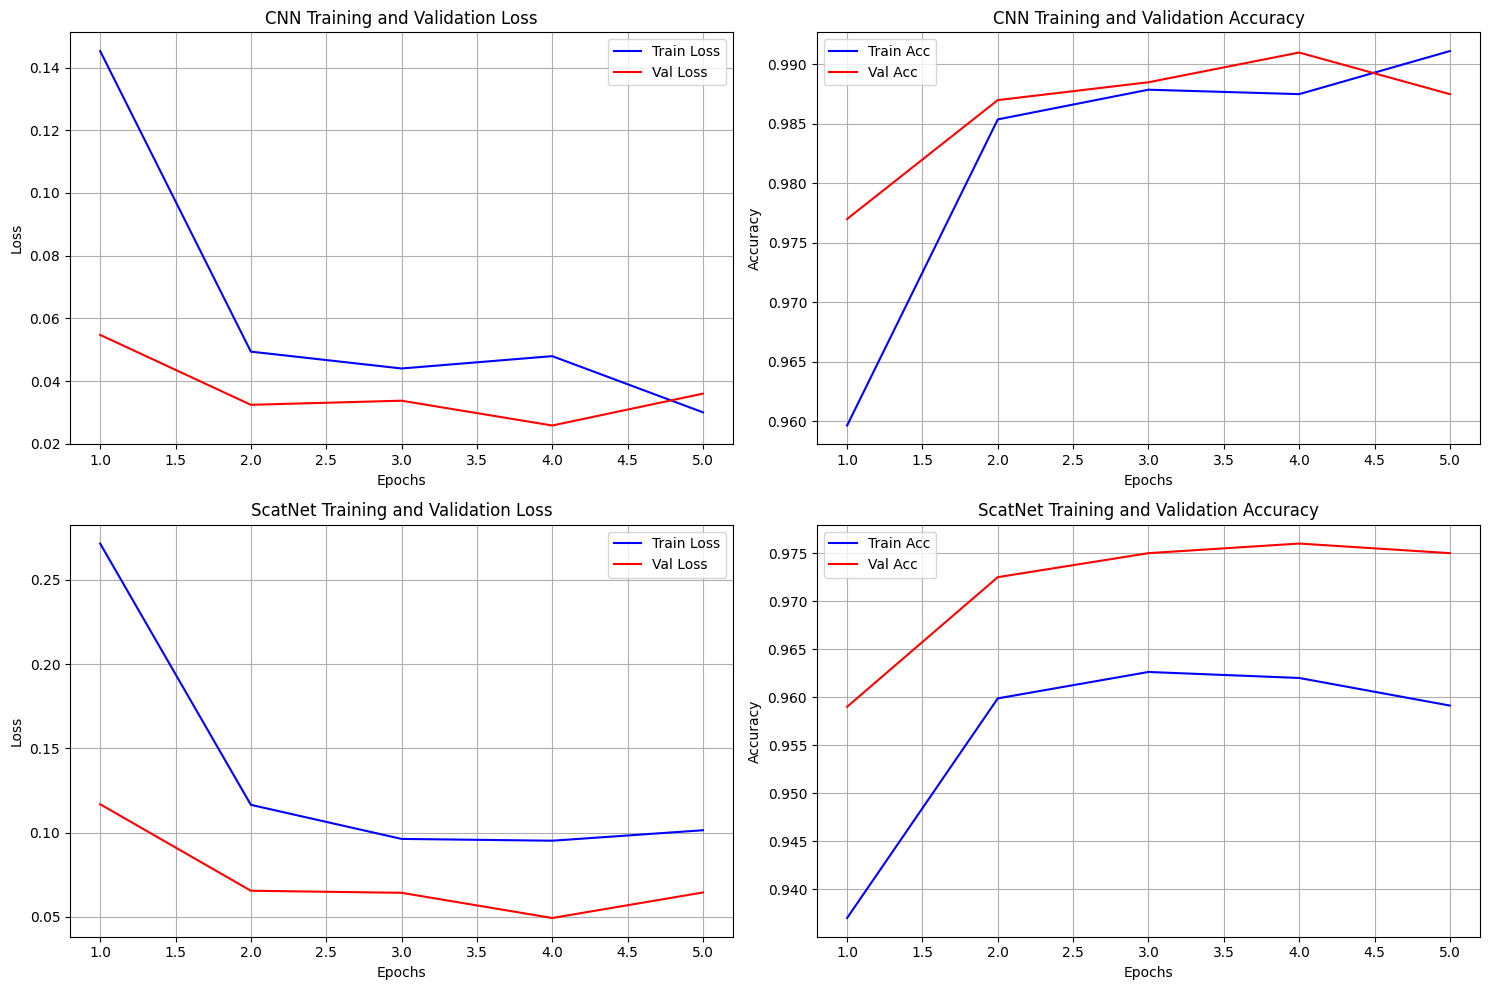

In [25]:
# Access pre-calculated history
cnn_history = cnn_history
scatnet_history = scatnet_history

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, 6)
ax1.plot(epochs_range, cnn_history['train_losses'], 'b-', label='Train Loss')
ax1.plot(epochs_range, cnn_history['val_losses'], 'r-', label='Val Loss')
ax1.set_title('CNN Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs_range, cnn_history['train_accs'], 'b-', label='Train Acc')
ax2.plot(epochs_range, cnn_history['val_accs'], 'r-', label='Val Acc')
ax2.set_title('CNN Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

ax3.plot(epochs_range, scatnet_history['train_losses'], 'b-', label='Train Loss')
ax3.plot(epochs_range, scatnet_history['val_losses'], 'r-', label='Val Loss')
ax3.set_title('ScatNet Training and Validation Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True)

ax4.plot(epochs_range, scatnet_history['train_accs'], 'b-', label='Train Acc')
ax4.plot(epochs_range, scatnet_history['val_accs'], 'r-', label='Val Acc')
ax4.set_title('ScatNet Training and Validation Accuracy')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# Task
Generate a technical report for the lung cancer classification project, including project overview, methodology, model performance (k-fold cross-validation, learning curves, final evaluation with confusion matrices), XAI analysis using Integrated Gradients, model analysis (CNN filter visualization, classifier comparison), and a conclusion.

## Project overview

### Subtask:
Write a brief introduction to the project, including the goal (lung cancer classification) and the models used (CNN and ScatNet).


**Reasoning**:
Write the introduction to the technical report, introducing the project goal and the models used.



In [21]:
print("""
# Lung Cancer Classification Technical Report

## 1. Introduction

This technical report details a project focused on the crucial task of lung cancer classification using medical images. Accurate and timely identification of lung cancer is paramount for effective treatment and improved patient outcomes. This project explores and compares the performance of two distinct deep learning architectures for this binary classification problem: a traditional Convolutional Neural Network (CNN) and a Scattering Network (ScatNet). The aim is to evaluate their effectiveness in distinguishing between adenocarcinoma and benign lung tissue images.
""")


# Lung Cancer Classification Technical Report

## 1. Introduction

This technical report details a project focused on the crucial task of lung cancer classification using medical images. Accurate and timely identification of lung cancer is paramount for effective treatment and improved patient outcomes. This project explores and compares the performance of two distinct deep learning architectures for this binary classification problem: a traditional Convolutional Neural Network (CNN) and a Scattering Network (ScatNet). The aim is to evaluate their effectiveness in distinguishing between adenocarcinoma and benign lung tissue images.



## Methodology

### Subtask:
Describe the dataset, data loading and splitting, data augmentation and preprocessing, model architectures (CNN and ScatNet), training process (including k-fold cross-validation), and evaluation metrics (accuracy and F1 score).


**Reasoning**:
Add a new markdown section for Methodology and describe the dataset, data loading, splitting, augmentation, preprocessing, model architectures, training process, and evaluation metrics as per the instructions.



In [22]:
print("""
## 2. Methodology

### 2.1 Dataset

The project utilizes a dataset containing medical images of lung tissue, categorized into two classes for binary classification: adenocarcinoma (representing malignant cases) and benign (representing non-cancerous cases). A subset of 10,000 images was used for this study, comprising 5,000 adenocarcinoma images and 5,000 benign images.

### 2.2 Data Loading and Splitting

Image data was loaded by iterating through the respective class directories and storing the file paths along with their corresponding labels (1 for adenocarcinoma, 0 for benign). The dataset was then split into training and testing sets using an 80/20 ratio. Stratified splitting was applied to ensure that the proportion of adenocarcinoma and benign images was maintained in both the training and testing sets, mitigating potential class imbalance issues during model training and evaluation.

### 2.3 Data Augmentation and Preprocessing

To enhance model generalization and prevent overfitting, data augmentation techniques were applied to the training set. These included resizing images to 224x224 pixels and applying random horizontal flips with a probability of 0.5. For both training and testing sets, images were converted to PyTorch tensors and normalized using the mean and standard deviation values calculated from the ImageNet dataset (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]). This normalization is a standard practice when working with pre-trained models or models trained on datasets with similar characteristics.

### 2.4 Model Architectures

Two distinct model architectures were employed and compared:

*   **Convolutional Neural Network (CNN):** A standard CNN architecture was implemented, consisting of three convolutional layers with increasing filter sizes (32, 64, 128), each followed by a ReLU activation and max pooling. Dropout layers were included after the fully connected layers for regularization. The convolutional layers extract hierarchical features from the input images, which are then flattened and passed to a classifier composed of three fully connected layers to produce the final class predictions.

*   **Scattering Network (ScatNet):** The ScatNet model leverages the Scattering Transform as its initial feature extraction layer. The 2D Scattering Transform (with parameters J=2, shape=(224, 224), L=8) provides a translation-invariant and stable representation of the input images, capturing multi-scale information. The features generated by the Scattering Transform are then fed into the same classifier architecture as the CNN, consisting of three fully connected layers for classification.

### 2.5 Training Process

Both the CNN and ScatNet models were trained using the Cross-Entropy Loss function, a common choice for multi-class classification problems. The Adam optimizer was used for updating the model weights during training. The models were trained for 5 epochs each on the full training dataset after the k-fold cross-validation.

To obtain a robust estimate of each model's performance and to assess their generalization capability, 5-fold stratified cross-validation was performed on the training data. The training set was divided into five folds; in each iteration, four folds were used for training, and one fold was used for validation. This process was repeated five times, with each fold serving as the validation set once.

### 2.6 Evaluation Metrics

The performance of the models was evaluated using the following metrics:

*   **Accuracy:** The proportion of correctly classified images out of the total number of images. It is a straightforward measure of overall correctness.
*   **F1 Score:** The harmonic mean of precision and recall. The weighted average F1 score was used to account for potential class imbalance, providing a balanced measure of the model's performance on both classes.

""")


## 2. Methodology

### 2.1 Dataset

The project utilizes a dataset containing medical images of lung tissue, categorized into two classes for binary classification: adenocarcinoma (representing malignant cases) and benign (representing non-cancerous cases). A subset of 10,000 images was used for this study, comprising 5,000 adenocarcinoma images and 5,000 benign images.

### 2.2 Data Loading and Splitting

Image data was loaded by iterating through the respective class directories and storing the file paths along with their corresponding labels (1 for adenocarcinoma, 0 for benign). The dataset was then split into training and testing sets using an 80/20 ratio. Stratified splitting was applied to ensure that the proportion of adenocarcinoma and benign images was maintained in both the training and testing sets, mitigating potential class imbalance issues during model training and evaluation.

### 2.3 Data Augmentation and Preprocessing

To enhance model generalization and prevent overf

## Results - model performance

### Subtask:
Present the k-fold cross-validation results for both models, including mean accuracy and F1 scores with standard deviations.


**Reasoning**:
Access the pre-calculated results and calculate the standard deviations, then print the formatted section for the technical report including the k-fold cross-validation results.



In [23]:
import numpy as np

# Access pre-calculated mean values
cnn_mean_acc = cnn_mean_acc
cnn_mean_f1 = cnn_mean_f1
scatnet_mean_acc = scatnet_mean_acc
scatnet_mean_f1 = scatnet_mean_f1

# Calculate standard deviations
cnn_acc_std = np.std(cnn_fold_accs)
cnn_f1_std = np.std(cnn_fold_f1s)
scatnet_acc_std = np.std(scatnet_fold_accs)
scatnet_f1_std = np.std(scatnet_fold_f1s)

print("""
## 3. Results

### 3.1 K-Fold Cross-Validation

K-fold cross-validation was performed to evaluate the robustness and generalization performance of the CNN and ScatNet models. The following table summarizes the mean accuracy and mean F1 scores obtained across the 5 folds:

| Model   | Mean Accuracy (± Std Dev) | Mean F1 Score (± Std Dev) |
|---------|---------------------------|---------------------------|
| CNN     | {:.4f} ± {:.4f}          | {:.4f} ± {:.4f}          |
| ScatNet | {:.4f} ± {:.4f}          | {:.4f} ± {:.4f}          |

""".format(cnn_mean_acc, cnn_acc_std, cnn_mean_f1, cnn_f1_std,
           scatnet_mean_acc, scatnet_acc_std, scatnet_mean_f1, scatnet_f1_std))


## 3. Results

### 3.1 K-Fold Cross-Validation

K-fold cross-validation was performed to evaluate the robustness and generalization performance of the CNN and ScatNet models. The following table summarizes the mean accuracy and mean F1 scores obtained across the 5 folds:

| Model   | Mean Accuracy (± Std Dev) | Mean F1 Score (± Std Dev) |
|---------|---------------------------|---------------------------|
| CNN     | 0.9749 ± 0.0107          | 0.9749 ± 0.0107          |
| ScatNet | 0.9681 ± 0.0036          | 0.9681 ± 0.0036          |


